In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [3]:
from juneja.validation_pipeline.preprocess import img_to_tensor
from juneja.validation_pipeline.metrics import normalize, match_hist, normalize_map, SIM, CC, NSS
from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from shardul.ScoreCAM.utils.visualize import visualize, reverse_normalize
from shardul.ScoreCAM.utils.imagenet_labels import label2idx, idx2label


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


In [4]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

2023-11-01 16:09:07.343386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:09:08.708311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/smitra/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/smitra/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-11-01 16:09:08.708456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7

In [5]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_gpu.eval();
target_layer = model_gpu.layer4[1].conv2
classes = get_imagenet_classes()
resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

scorecam_wrapped_model = ScoreCAM(model_gpu, target_layer)
gradcam_wrapped_model = GradCAM(model_gpu, target_layer)

Using cache found in /home/smitra/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def gkern(l=5, sig=1.):
    # side length `l`
    # sigma `sig`
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def generate_focus_point(img, focus_points):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for idx, fp in enumerate(focus_points):
        p, r, fill_value = fp
        left_up_point = (p[0]-r, p[1]-r)
        right_down_point = (p[0]+r, p[1]+r)
        two_point_list = [left_up_point, right_down_point]
        draw.ellipse(two_point_list, fill=fill_value)
    img_np = np.array(img)
    kernel = gkern(30, 7)
    img_np = convolve2d(img_np, kernel, mode="same")
    return img_np

In [32]:
def plot_comparison_focus_points(focus_points, changes, name):
    fig , axes = plt.subplots(ncols=2, nrows=1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    sal_1 = generate_focus_point(blank_img, focus_points)
    axes[0].imshow(sal_1)
    axes[0].set_title("Reference")
    for idx, fp in enumerate(focus_points):
        xy, r, fill_value = fp
        x, y = xy
        axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
        

    changed_focus_ps = []
    for idx, change in enumerate(changes):
        translate, scale, value = change
        fp = []
        pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
        fp.append(pos)
        fp.append(focus_points[idx][1] * scale)
        fp.append(focus_points[idx][2] * value)
        changed_focus_ps.append(fp)

    sal_2 = generate_focus_point(blank_img, changed_focus_ps)
    axes[1].imshow(sal_2)
    for idx, fp in enumerate(changed_focus_ps):
        xy, r, fill_value = fp
        x, y = xy
        axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    axes[1].set_title(f"Comparative. CC = {CC(sal_1, sal_2):.4f}");
    for ax in axes:
        ax.axis('off')
    fig.suptitle("CC", fontsize=16, fontweight="bold", y=0.7, x = 0.51)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Background/Metrics/CC/{name}.png")

In [33]:
blank_img = np.zeros((224, 224))
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 15, 0.4], # 1
                [[100, 160], 10, 0.8], # 2
                [[160, 100], 16, 0.4], # 3
                [[75, 90], 15, 0.7]]  # 4

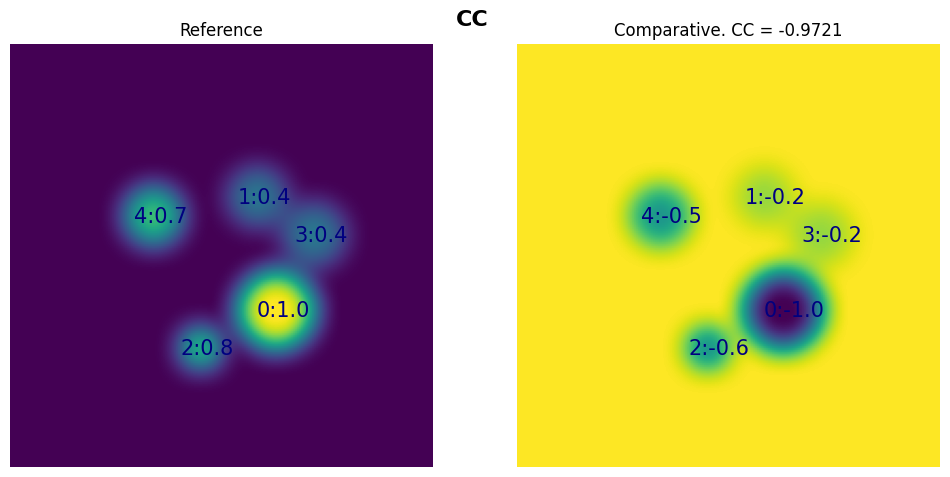

In [34]:
# The relative values within the objects does not change the metric all that much
# In here the values have been lessened yet the value barely changes
plot_comparison_focus_points(focus_points, [[(0, 0), 1, -1], # 0
                                                [(0, 0), 1, -0.4], # 1
                                                [(0, 0), 1, -0.8], # 2
                                                [(0, 0), 1, -0.4], # 3
                                                [(0, 0), 1, -0.7]], 'Saliency_location_same') # 4

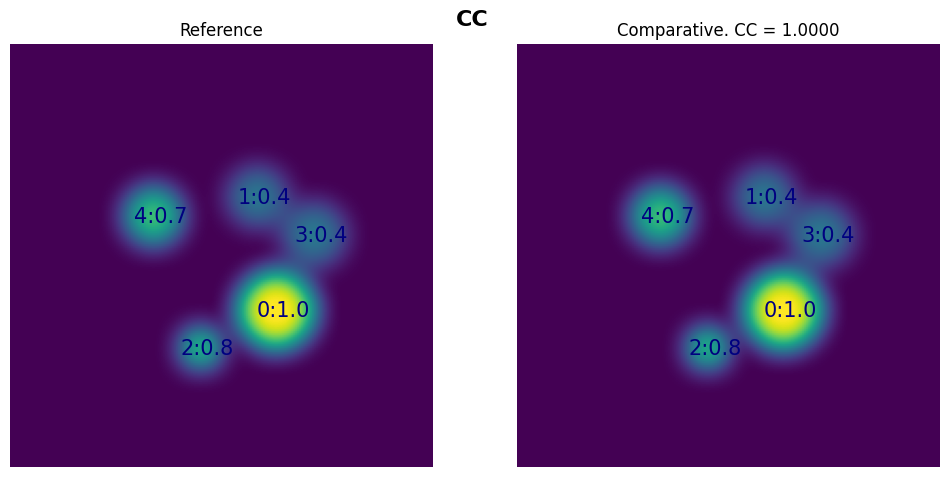

In [35]:
# Positive case where the both the saliencies are same in location and intensity
plot_comparison_focus_points(focus_points, [[(0, 0), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(0, 0), 1, 1], # 2
                                                [(0, 0), 1, 1], # 3
                                                [(0, 0), 1, 1]], 'Saliency_original') # 4

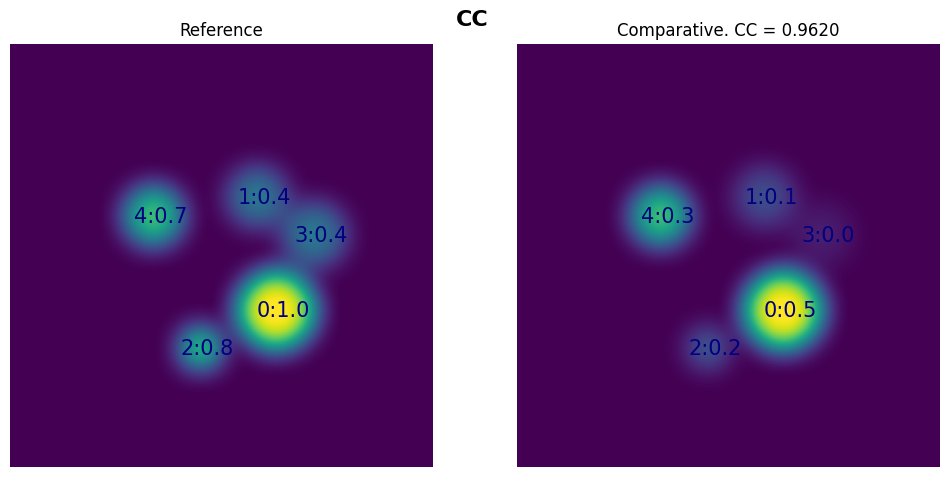

In [36]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(0, 0), 1, 0.5], # 0
                                                [(0, 0), 1, 0.3], # 1
                                                [(0, 0), 1, 0.2], # 2
                                                [(0, 0), 1, 0.1], # 3
                                                [(0, 0), 1, 0.5]], name = 'Saliency_intensity_change_CC') # 4

In [ ]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(-25, 10), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(-55, 15), 1, 1], # 2
                                                [(30, -40), 1, 1], # 3
                                                [(20, 30), 1, 1]], name = 'Saliency_intensity_change_CC') # 4